In [ ]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

In [ ]:
# Import the relevant modules
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.instruct.train_policy as tp
import sousvide.visualize.plot_synthesize as ps
import sousvide.visualize.plot_learning as pl
import sousvide.flight.deploy_figs as df

In [ ]:
import figs.utilities.config_helper as ch
import figs.tsplines.min_snap as ms
import figs.utilities.trajectory_helper as th
import matplotlib.pyplot as plt
import numpy as np

def get_fig():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plim = np.array([
        [-6.0, 0.0],
        [-2.0, 2.0],
        [-0.5,-1.5]])
    ratio = plim[:,1]-plim[:,0]
    xlim = plim[0,:]
    ylim = plim[1,:]
    zlim = plim[2,:]

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    ax.set_box_aspect(ratio)  # aspect ratio is 1:1:1 in data space

    ax.invert_zaxis()
    ax.invert_yaxis()

    return fig, ax

(24,) (24, 24)


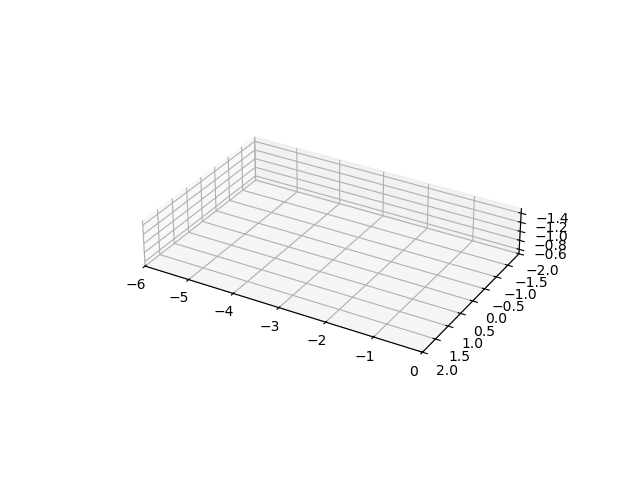

In [40]:
cohort = "transformers"             # cohort name
markers = ['o', 's', '^', 'D', 'v', 'p', '*', '+', 'x', '|', '_']
fig, ax = get_fig()

noff = 1
idx_cp = 2
# course = ch.get_config("robustness_track","courses")
course = ch.get_config("line","courses")
ms_out = ms.solve(course["waypoints"],20)

QP = ms_out["QP"]
x,P,q = QP["x"],QP["P"],QP["q"]

print(x.shape,P.shape)
# cost = 0.5*QP["x"].T@QP["P"]@QP["x"] + QP["q"].T@QP["x"]
# print(cost)



In [ ]:

# Tps,CPs = ms_out["CP"]
# CP0 = CPs[idx_cp-1,:,:]
# CP1 = CPs[idx_cp,:,:]
# CP2 = CPs[idx_cp+1,:,:]
# CPm = np.hstack((CP1[:,noff:],CP2[:,1:noff+1]))

# N = 100
# T = np.linspace(0.0,1.0,N)
# P0 = np.zeros((3,N))
# P1 = np.zeros((3,N))
# P2 = np.zeros((3,N))
# Pm = np.zeros((3,N))

# for i in range(N):
#     fo0 = th.CP_to_fo(T[i],1.0,CP0,4,4)
#     fo1 = th.CP_to_fo(T[i],1.0,CP1,4,4)
#     fo2 = th.CP_to_fo(T[i],1.0,CP2,4,4)
#     fom = th.CP_to_fo(T[i],1.0,CPm,4,4)

#     P0[:,i] = fo0[0:3,0]
#     P1[:,i] = fo1[0:3,0]
#     P2[:,i] = fo2[0:3,0]
#     Pm[:,i] = fom[0:3,0]

# ax.scatter(CP0[0,:], CP0[1,:], CP0[2,:], color='C0', marker=markers[0])
# ax.scatter(CP1[0,:], CP1[1,:], CP1[2,:], color='C1', marker=markers[1])
# ax.scatter(CP2[0,:], CP2[1,:], CP2[2,:], color='C2', marker=markers[2])
# ax.scatter(CPm[0,:], CPm[1,:], CPm[2,:], color='k', marker=markers[3])
# ax.plot(P0[0,:], P0[1,:], P0[2,:],color='C0')
# ax.plot(P1[0,:], P1[1,:], P1[2,:],color='C1')
# ax.plot(P2[0,:], P2[1,:], P2[2,:],color='C2')
# ax.plot(Pm[0,:], Pm[1,:], Pm[2,:],color='k')

# plt.show()
# plt.tight_layout()